# Imports

In [64]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pickle as pk
import numpy as np
import sklearn.manifold as man
from tensorflow.python.framework import ops

from model import Emoji2Vec, ModelParams
from phrase2vec import Phrase2Vec
from phrase2vec_rnn import Phrase2VecRNN
from utils import build_kb, get_examples_from_kb, generate_embeddings, get_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initializations
This step takes a while to execute, wait for 'DONE'

## Constants and Hyperparameters

In [65]:
word2vec_path = './data/word2vec/GoogleNews-vectors-negative300.bin'
mapping_path = 'emoji_mapping.p'
data_folder = './data/training/'
embeddings_file = 'generated_embeddings.p'

in_dim = 300   # Length of word2vec vectors
out_dim = 300  # Desired dimension of output vectors
pos_ex = 4
neg_ratio = 1
max_epochs = 40
dropout = 0.1

params = ModelParams(in_dim=in_dim, out_dim=out_dim, pos_ex=pos_ex, max_epochs=max_epochs,
                    neg_ratio=neg_ratio, learning_rate=0.001, dropout=dropout, class_threshold=0.5)


ckpt_path = params.model_folder('unicode') + '/model.ckpt'
e2v_path = params.model_folder('unicode') + '/emoji2vec.bin'
print(e2v_path)

./results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/emoji2vec.bin


## Build Knowledge Base

In [66]:
print('reading training data from: ' + data_folder)
train_kb, ind2phr, ind2emoj = build_kb(data_folder)

pk.dump(ind2emoj, open(mapping_path, 'wb'))

reading training data from: ./data/training/


## Read or Generate Embeddings

In [67]:
embeddings_array = generate_embeddings(ind2phr=ind2phr, kb=train_kb, embeddings_file=embeddings_file,
                                             word2vec_file=word2vec_path)
print('DONE')

reading embedding data from: ./data/word2vec/GoogleNews-vectors-negative300.bin
generating vector subset
DONE


## Initialize models and mappings

In [68]:
print('Initializing: reading embedding data from: ' + word2vec_path)
# get the vector for a phrase
phraseVecModel = Phrase2Vec.from_word2vec_paths(params.in_dim, word2vec_path, e2v_path)
# phraseVecModel = Phrase2VecRNN(300, w2v_path=word2vec_path)
print('DONE')

Initializing: reading embedding data from: ./data/word2vec/GoogleNews-vectors-negative300.bin


In [69]:
ops.reset_default_graph()

# mapping from id to emoji
mapping = pk.load(open(mapping_path, 'rb'))
# mapping from emoji to id
inv_map = {v: k for k, v in mapping.items()}

# tensorflow model
model = Emoji2Vec(params, len(mapping), embeddings_array=embeddings_array)
print('DONE')

DONE


In [70]:
# initialize tensorflow session
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

INFO:tensorflow:Restoring parameters from ./results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/model.ckpt


# Performance Measures
Check the accuracy, f1 score, auc, and the auc graph

In [71]:
def measures(example_type):
    train_kb, ind2phr, ind2emoj = build_kb(data_folder)
    ex_set = get_examples_from_kb(kb=train_kb, example_type=example_type)

    # evaluate the dev. accuracy using this as the threshold
    thresh = 0.5

    acc = model.accuracy(session=session, dset=ex_set, threshold=thresh)
    f1 = model.f1_score(session=session, dset=ex_set)
    print(str.format('Accuracy at thresh={}: {}', thresh, f1))
    print(str.format('F1 score: {}', f1))
    
    try:
        auc = model.auc(session=session, dset=ex_set)


        print(str.format('AUC score: {}', auc))

        fpr, tpr, thresholds = model.roc_vals(session=session, dset=ex_set)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(fpr, tpr)
        ax.set_title("ROC Curve for learned emoji")
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")

        #
        #for i , val in enumerate(thresholds):
        #    if i % 10 == 0:
        #        plt.annotate(val, (fpr[i], tpr[i]))

        plt.grid()
        plt.show()
    except:
        print('Can\'t compute AUC or ROC')

In [72]:
print('Train Set')
measures('train')

Train Set
Accuracy at thresh=0.5: 0.677709417889257
F1 score: 0.677709417889257
Can't compute AUC or ROC


Dev Set
Accuracy at thresh=0.5: 0.4867075664621677
F1 score: 0.4867075664621677
AUC score: 0.494992


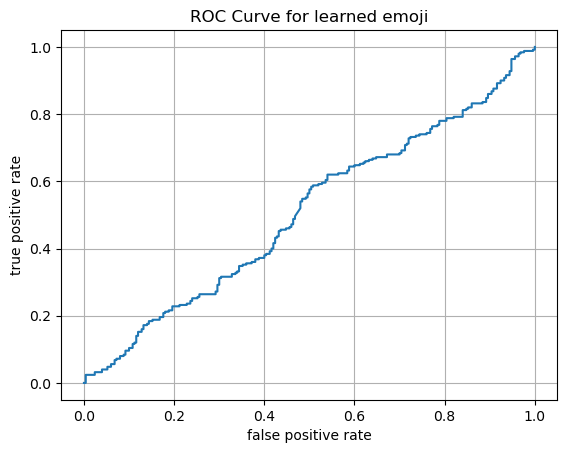

In [73]:
print('Dev Set')
measures('dev')

Test Set
Accuracy at thresh=0.5: 0.5081300813008129
F1 score: 0.5081300813008129
AUC score: 0.519856


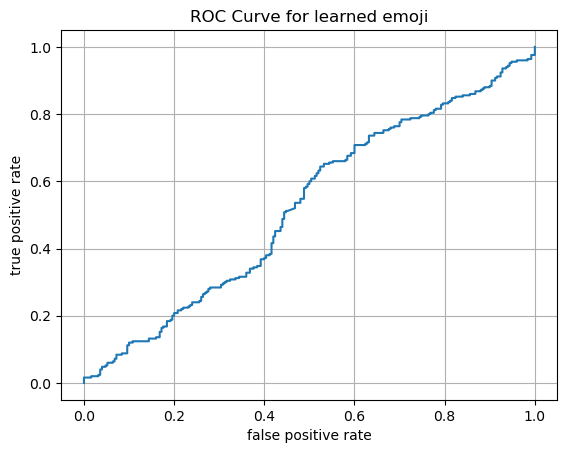

In [51]:
print('Test Set')
measures('test')

In [52]:
# RESET THE GRAPH
ops.reset_default_graph()
model = Emoji2Vec(params, len(mapping), embeddings_array=None, use_embeddings=False)

session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

INFO:tensorflow:Restoring parameters from ./results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/model.ckpt


# Top Emoji Query
Set `phr` as a phrase, and get the top `N` emojis correlating to that phrase.

In [30]:
phr = 'happy face'
N = 5

# get the vector representaiton
vec = phraseVecModel[phr][0]

# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([vec])
    })
    res.append(predict)

# print the top N emoji
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

ValueError: Cannot feed value of shape (1,) for Tensor orig_vec:0, which has shape (?, 300)

# Top Phrase Query
Set `em` as an emoji, and get the top `N` phrases correlating to that emoji.

In [31]:
# input
em = '😁'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
vec = emoji_vecs[inv_map[em]]

# print top N phrases
for word, score in phraseVecModel.from_emoji([vec], top_n=N):
    print(str.format("{}\t{}", word, score))

harness	0.23982860147953033
Malta_Shipyards	0.23912212252616882
Sanskrit_libretto	0.23725679516792297
Quad_NROM	0.23705309629440308
SanDisk	0.23697210848331451
Brickworks	0.23412661254405975
IISCO	0.23298464715480804
Valora_Retail	0.2317621260881424
Worde	0.2310117781162262
Yatala	0.22974008321762085


# Analogy Task
Set `base` as a base emoji, `minus` as an emoji to subtract from the base, `plus` as an emoji to add, and get the top `N` correlating phrases and emojis relating to this analogy. 

In [32]:
def print_analogy_result(base, minus, plus):
    emoji_vecs = session.run(model.V)
    total = phraseVecModel[base] - phraseVecModel[minus] + phraseVecModel[plus]
    
    res = list()
    for colIx in range(0, len(mapping)):
        predict = session.run(model.prob, feed_dict={
            model.col: np.array([colIx]),
            model.orig_vec: np.array([total / np.linalg.norm(total)])
        })
        res.append(predict)
        
    ems = sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:5]
    print(str.format('{} - {} + {} = {}', base, minus, plus, [mapping[em] for em in ems]))

In [38]:
print_analogy_result('👑', '🚹', '🚺')
print_analogy_result('💵', '🇺🇸', '🇬🇧')
print_analogy_result('💵', '🇺🇸', '🇪🇺')
print_analogy_result('👦', '👨', '👩')
print_analogy_result('👪', '👦', '👧')
print_analogy_result('🕶', '☀️', '⛈')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [53]:
# input
base = '👑'
# base = '👨'
minus = '🚹'
plus = '🚺'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
total = emoji_vecs[inv_map[base]] - emoji_vecs[inv_map[minus]] + emoji_vecs[inv_map[plus]]

# print the top N phrases
print(str.format('Top {} matching phrases:', N))
print()
for word, score in phraseVecModel.from_emoji([total], top_n=N):
    print(str.format("{}\t{}", word, score))
    
# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([total / np.linalg.norm(total)])
    })
    res.append(predict)

# print the top N emoji
print()
print(str.format('Top {} matching emoji:', N))
print()
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

Top 10 matching phrases:

CASSOPOLIS	0.25659024715423584
Laura_DiDio_principal	0.2551117241382599
Oxymoron	0.25469517707824707
Ebou_Manneh	0.24704119563102722
Human_Centipede	0.24366866052150726
Secret_Apprentice	0.24211357533931732
Abdelsalam	0.2419479787349701
MAARS	0.24188335239887238
Prosecutor_Tomas_Lindstrand	0.24046561121940613
Empirical_Analysis	0.24024491012096405

Top 10 matching emoji:

👑 [0.9939852]
👸 [0.99198747]
🚺 [0.9623356]
🏰 [0.9471969]
🐞 [0.94589984]
👛 [0.9330509]
💂 [0.92808366]
🐝 [0.92036724]
🎎 [0.9117151]
🏃 [0.90609634]


# Visualize Emoji Vector Space
2-D projection of the Emoji vector space, using t-SNE.

Jupyter won't plot emoji. Use visualize.py to see a clearer picture.

/Users/ritotanaka/miniconda3/envs/cs375/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ritotanaka/miniconda3/envs/cs375/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127472 (\N{REGIONAL INDICATOR SYMBOL LETTER K}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ritotanaka/miniconda3/envs/cs375/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128084 (\N{NECKTIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ritotanaka/miniconda3/envs/cs375/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ritotanaka/miniconda3/envs/cs375/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarnin

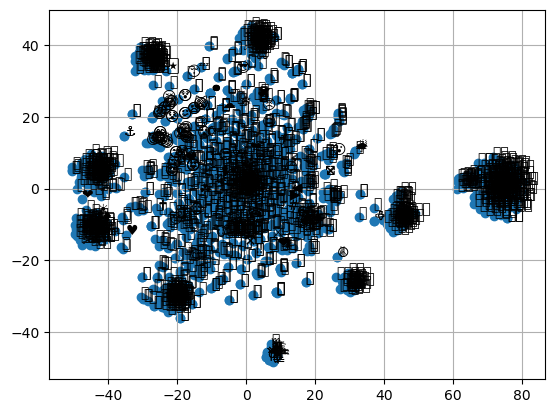

In [31]:
V = session.run(model.V)

fig = plt.figure()
ax = fig.add_subplot(111)
tsne = man.TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
trans = tsne.fit_transform(V)
x, y = zip(*trans)
plt.scatter(x, y)

for i in range(len(trans)):
    ax.annotate(mapping[i], xy=trans[i], textcoords='data')

plt.grid()
plt.show()